In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from utilities import *
from tqdm import tqdm

In [88]:
x_train, y_train, x_test, y_test = load_data()

In [89]:
print(f"Dimension of x_train : {x_train.shape}")
print(f"Dimension of y_train : {y_train.shape}")
print(np.unique(y_train, return_counts=True))

Dimension of x_train : (1000, 64, 64)
Dimension of y_train : (1000, 1)
(array([0., 1.]), array([500, 500]))


In [90]:
print(f"Dimension of  x_test: {x_test.shape}")
print(f"Dimension of y_test : {y_test.shape}")
print(np.unique(y_test, return_counts=True))

Dimension of  x_test: (200, 64, 64)
Dimension of y_test : (200, 1)
(array([0., 1.]), array([100, 100]))


/home/remir/.local/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


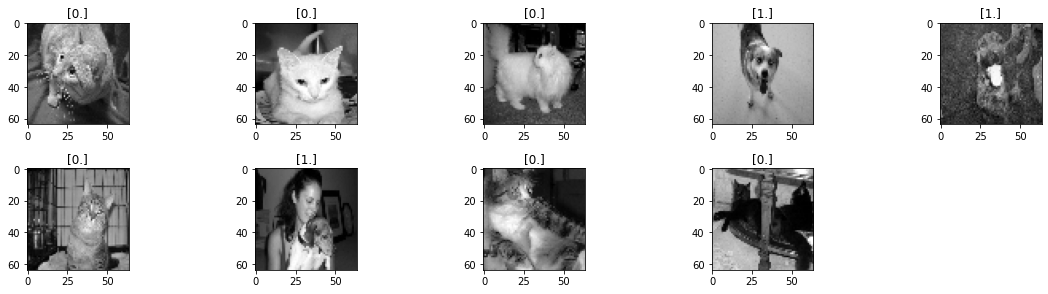

In [91]:
plt.figure(figsize=(16,8))
for i in range(1,10):
    plt.subplot(4, 5, i)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.tight_layout()
plt.show()

In [92]:
def normalize(A, min=0, max=255):
    return (A - min) / (max - min)

In [93]:
x_train_norm = normalize(x_train, min=x_train.min(), max=x_train.max())
x_test_norm = normalize(x_test, min=x_train.min(), max=x_train.max())

print(f"Dimension of  x_train_norm: {x_train_norm.shape}")
print(f"Dimension of  x_test_norm: {x_test_norm.shape}")

Dimension of  x_train_norm: (1000, 64, 64)
Dimension of  x_test_norm: (200, 64, 64)


In [94]:
def flat_image(A):
    m = A.shape[0]
    image_size = A.shape[1] * A.shape[2]
    B = A.flatten().reshape(m, image_size)
    return B

In [95]:
x_train_flat = flat_image(x_train_norm)
x_test_flat = flat_image(x_test_norm)

print(f"Dimension of  x_train_flat: {x_train_flat.shape}")
print(f"Dimension of  x_test_flat: {x_test_flat.shape}")

# On transpose pour l'utilisation du réseau de neurones
x_train_flat = x_train_flat.T
y_train = y_train.T

x_test_flat = x_test_flat.T
y_test = y_test.T

print("---")
print("On transpose pour l'utilisation du réseau de neurones")
print(f"Dimension of  x_train_flat: {x_train_flat.shape}")
print(f"Dimension of  y_train: {y_train.shape}")
print(f"Dimension of  x_test_flat: {x_test_flat.shape}")
print(f"Dimension of  y_test: {y_test.shape}")

Dimension of  x_train_flat: (1000, 4096)
Dimension of  x_test_flat: (200, 4096)
---
On transpose pour l'utilisation du réseau de neurones
Dimension of  x_train_flat: (4096, 1000)
Dimension of  y_train: (1, 1000)
Dimension of  x_test_flat: (4096, 200)
Dimension of  y_test: (1, 200)


In [96]:
def initialisation(dimensions):
    params = {}
    C = len(dimensions)
    for c in range(1, C):
        params["W" + str(c)] = np.random.randn(dimensions[c], dimensions[c-1])
        params["b" + str(c)] = np.random.randn(dimensions[c], 1)

    return params

In [97]:
def sigmoid(A):
    return 1/(1 + np.exp(-A))

In [98]:
def forward_propagation(X, params):
    activations = { "A0": X }
    C = len(params) // 2

    for c in range(1, C + 1):
        Z = params["W" + str(c)].dot(activations["A" + str(c - 1)]) + params["b" + str(c)]
        activations["A" + str(c)] = sigmoid(Z)

    return activations

In [99]:
def log_loss(A, y, epsilon=1e-15):
    m = len(y)
    return -(1/m)*np.sum(y*np.log(A + epsilon) + (1-y)*np.log(1 - A + epsilon))

In [100]:
def back_propagation(X, y, activations, params):
    gradients = {}
    C = len(params) // 2
    m = y.shape[1]

    dZ = activations["A" + str(C)] - y

    for c in reversed(range(1, C + 1)):
        gradients["dW" + str(c)] = (1/m) * np.dot(dZ, activations["A" + str(c - 1)].T)
        gradients["db" + str(c)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        if c > 1:
            dZ = np.dot(params["W" + str(c)].T, dZ) * activations["A" + str(c-1)] * (1 - activations["A" + str(c-1)])

    return gradients

In [101]:
def update(params, gradients, learning_rate):
    C = len(params) // 2
    new_params = {}
    for c in range(1, C + 1):
        new_params["W" + str(c)] = params["W" + str(c)] - learning_rate * gradients["dW" + str(c)]
        new_params["b" + str(c)] = params["b" + str(c)] - learning_rate * gradients["db" + str(c)]

    return new_params

In [102]:
def predict(X, params):
    C = len(params) // 2
    activations = forward_propagation(X, params)
    A_final = activations["A" + str(C)]
    return A_final >= 0.5

In [103]:
def calcul_accuracy(X, y, params):
    y_pred = predict(X, params)
    return accuracy_score(y.flatten(), y_pred.flatten())

In [104]:
def neural_network(X, y, hidden_layer, learning_rate=0.1, n_iter=1000):
    history = {
        'loss': [],
        'accuracy': [],
    }
    
    dimensions = list(hidden_layer)
    dimensions.insert(0, X.shape[0])
    dimensions.append(y.shape[0])
    params = initialisation(dimensions)
    C = len(params) // 2
    
    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X, params)
        gradients = back_propagation(X, y, activations, params)
        params = update(params, gradients, learning_rate)

        if i % 10 == 0:
            A_train = activations["A" + str(C)]
            history['loss'].append(log_loss(A_train, y))
            history['accuracy'].append(calcul_accuracy(X, y, params))

    print(f"Accuracy score (train set): {calcul_accuracy(X, y, params)}")
    return (params, history)

In [105]:
def display_loss_acc(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(history['loss'])
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(history['accuracy'])
    plt.legend()
    plt.show()

In [106]:
(params, history) = neural_network(x_train_flat, y_train, hidden_layer=(32, 16, 16), learning_rate=0.1, n_iter=5000)

100%|██████████| 5000/5000 [11:20<00:00,  7.35it/s]

Accuracy score (train set): 0.788


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


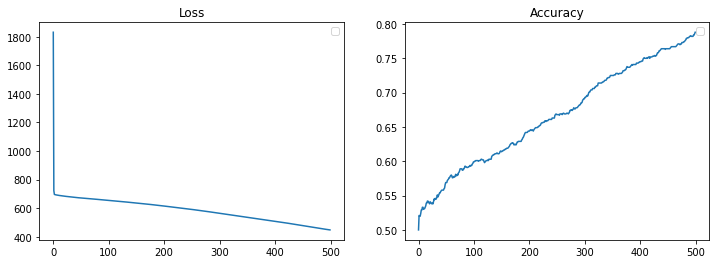

In [107]:
display_loss_acc(history)

In [108]:
calcul_accuracy(x_test_flat, y_test, params)

0.58